
--- Simple Linear Regression ---
MSE: 1.6225166189621596
R² Score: 0.09924809613354946


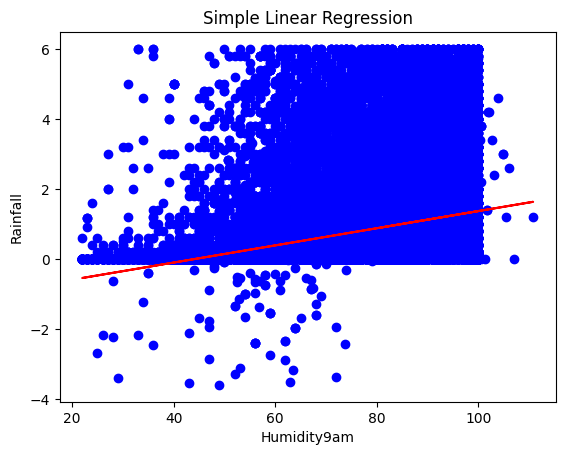


--- Multiple Linear Regression ---
MSE: 1.4629655963384467
R² Score: 0.18782400698250956


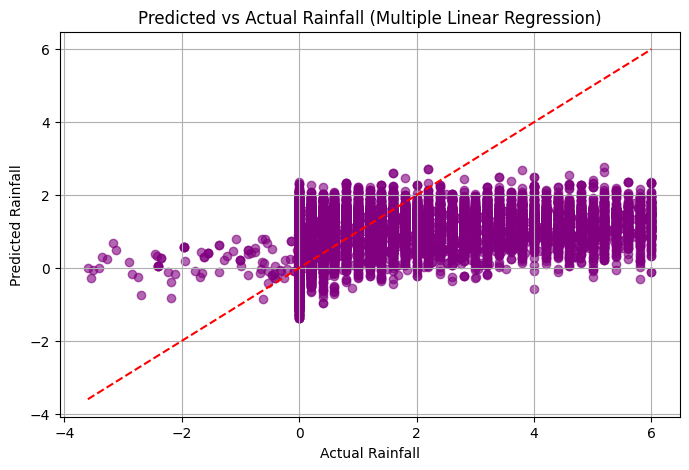

R² scores for each fold: [0.0587288  0.09629241 0.14057563 0.13803209 0.14169745]
Average R² score: 0.11506527464305698
MSE scores for each fold: [0.93063029 0.97953114 1.15172887 2.19035857 2.15270952]
Average MSE: 1.4809916790471553


In [1]:
# 1. Data Preprocessing Pipeline + Linear and Multiple Regression

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
full_data = pd.read_csv('weatherAUS.csv')
full_data['RainToday'].replace({'No': 0, 'Yes': 1}, inplace=True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace=True)

# Oversampling to balance
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

# Fill categorical missing values
for col in oversampled.select_dtypes(include=['object']).columns:
    oversampled[col] = oversampled[col].fillna(oversampled[col].mode()[0])

# Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

# MICE Imputation
mice_imputer = IterativeImputer()
MiceImputed = pd.DataFrame(mice_imputer.fit_transform(oversampled), columns=oversampled.columns)

# Remove outliers using IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) | (MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]

# ===== Simple Linear Regression =====
X_lin = MiceImputed[['Humidity9am']]
y_lin = MiceImputed['Rainfall']
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.25, random_state=42)
simple_model = LinearRegression()
simple_model.fit(X_train_lin, y_train_lin)
y_pred_lin = simple_model.predict(X_test_lin)
print("\n--- Simple Linear Regression ---")
print("MSE:", mean_squared_error(y_test_lin, y_pred_lin))
print("R² Score:", r2_score(y_test_lin, y_pred_lin))
plt.scatter(X_test_lin, y_test_lin, color='blue')
plt.plot(X_test_lin, y_pred_lin, color='red')
plt.xlabel('Humidity9am')
plt.ylabel('Rainfall')
plt.title('Simple Linear Regression')
plt.show()

# ===== Multiple Linear Regression =====
X_multi = MiceImputed[['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'Humidity9am', 'Humidity3pm',
                       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']]
y_multi = MiceImputed['Rainfall']
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.25, random_state=42)
multi_model = LinearRegression()
multi_model.fit(X_train_multi, y_train_multi)
y_pred_multi = multi_model.predict(X_test_multi)
print("\n--- Multiple Linear Regression ---")
print("MSE:", mean_squared_error(y_test_multi, y_pred_multi))
print("R² Score:", r2_score(y_test_multi, y_pred_multi))
plt.figure(figsize=(8, 5))
plt.scatter(y_test_multi, y_pred_multi, color='purple', alpha=0.6)
plt.plot([y_test_multi.min(), y_test_multi.max()], [y_test_multi.min(), y_test_multi.max()], 'r--')
plt.xlabel("Actual Rainfall")
plt.ylabel("Predicted Rainfall")
plt.title("Predicted vs Actual Rainfall (Multiple Linear Regression)")
plt.grid(True)
plt.show()

# ===== Cross-Validation on Multiple Linear Regression =====
model = LinearRegression()
r2_scores = cross_val_score(model, X_multi, y_multi, cv=5, scoring='r2')
print("R² scores for each fold:", r2_scores)
print("Average R² score:", np.mean(r2_scores))
neg_mse_scores = cross_val_score(model, X_multi, y_multi, cv=5, scoring='neg_mean_squared_error')
mse_scores = -neg_mse_scores
print("MSE scores for each fold:", mse_scores)
print("Average MSE:", np.mean(mse_scores))
